# War Task Analysis

In [1]:
cd ../../../../

/Users/adam2392/Documents/SPORF


In [2]:
import pandas as pd
from scipy import stats
import numpy as np
import mne
import mne_bids
from pathlib import Path
from mne.decoding import Scaler, Vectorizer
from mne_bids import make_bids_basename, read_raw_bids

from natsort import natsorted
from pprint import pprint
    
# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

import pickle
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import (KFold, StratifiedKFold,
                                     train_test_split,
                                     TimeSeriesSplit)
from sklearn.model_selection import (cross_val_score, RandomizedSearchCV)
    
# from rerf.rerfClassifier import rerfClassifier

import sys
print(sys.version)

from mtsmorf.io.read import (get_trial_info, 
                             read_dataset, read_label)
from mtsmorf.io.utils import (_generate_linspace_roc_from_dict, _plot_roc_curve)
from mtsmorf.war_exp.run_cv import cv_fit, run_exp, _load_data


import warnings
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2

3.8.2 | packaged by conda-forge | (default, Mar  5 2020, 16:54:44) 
[Clang 9.0.1 ]


# Define Subject to Analyze

Use BIDs entities to study the subjects

In [3]:
# bids identifiers
bids_root = Path("/Users/adam2392/Dropbox/efri/")
# bids_root = Path("/workspaces/research/data/efri/")
# bids_root = Path("/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/data/efri/")
deriv_path = Path(bids_root / "derivatives")

# subject identifiers
subject = "efri06"
session = "efri"
task = "war"
acquisition = "seeg"
run = "01"
kind = "ieeg"
# trial_id = 2

# bids filename
bids_basename = make_bids_basename(
    subject=subject,
    session=session,
    task=task,
    acquisition=acquisition,
    run=run,
#     suffix=f"{kind}.vhdr",
)

print("Reading data from: ", bids_basename)

Reading data from:  sub-efri06_ses-efri_task-war_acq-seeg_run-01


Load the data (Epochs)
----------------------

From each Epoch, we format the data as (X, y) pairs for supervised classification.

In [4]:
# read epochs data
epochs_show, y = _load_data(bids_basename, bids_root, event_key='show card', verbose=False)

# make sure y labels are properly binarized
lb = LabelBinarizer(neg_label=0, pos_label=1)
y = lb.fit_transform(y)
# print(y)

# read in epochs data for fixation
epochs_fixate, y = _load_data(bids_basename, bids_root, event_key='fixation', verbose=False)

Out of 186 trials, there were 185 successful trials in sub-efri06_ses-efri_task-war_acq-seeg_run-01.
Extracting parameters from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_events.tsv.
Reading channel info from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_channels.tsv.
Out of 186 trials, there were 185 successful trials in sub-efri06_ses-efri_task-war_acq-seeg_run-01.
Out of 186 trials, there were 185 successful trials in sub-efri06_ses-efri_task-war_acq-seeg_run-01.
Extracting parameters from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efr

In [5]:
print(epochs_show, epochs_fixate)
print(epochs_show.get_data().shape)
print(epochs_fixate.get_data().shape)

<Epochs  |   186 events (all good), 0 - 0.5 sec, baseline off, ~112.4 MB, data loaded,
 '10011': 186> <Epochs  |   186 events (all good), 0 - 0.5 sec, baseline off, ~112.4 MB, data loaded,
 '10007': 186>
(186, 79, 1001)
(186, 79, 1001)


In [6]:
# create X array
X = np.vstack((epochs_show.get_data(), epochs_fixate.get_data()))
y = np.hstack((np.ones(len(epochs_show)), np.zeros(len(epochs_fixate))))

print(X.shape, y.shape)

(372, 79, 1001) (372,)


Create a classifier
-------------------

Using a combination of MNE decoding objects and sklearn pipeline, we can setup a pipeline for running
a supervised classification experiment.

    * Scaler performs z-normalization across all channels 
    * Vectorizer reformats data into samples X features

Then the pipeline is fed as a sklearn classifier to a BaseSearchCV (e.g. RandomizedSearchCV), which 
optimizes using KFold CV based on a number of possible parameter settings.

In [7]:
# features, so the resulting filters used are spatio-temporal
clf = make_pipeline(
    Scaler(epochs_show.info),  # apply z-normalization across all channels
    Vectorizer(),
    RandomForestClassifier()
)

In [8]:
# make sure to hold out some data as test
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(X_train.shape, y_train.shape, X.shape)

(279, 79, 1001) (279,) (372, 79, 1001)


In [9]:
# feed in training to cross-validation, which will use training/validation data
# to iterate the classifier
cv_clf, outer_cv = cv_fit(clf, X_train, y_train, shuffle=True, apply_groups=False)

{'randomforestclassifier__max_depth': [None],
 'randomforestclassifier__max_features': ['auto'],
 'randomforestclassifier__min_samples_split': [2],
 'randomforestclassifier__n_estimators': [200]}
(279, 79, 1001) (279,)
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   15.6s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.6s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    9.7s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.9s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    9.5s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   10.2s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    7.4s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.1s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    7.5s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    7.5s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    7.5s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.4s finished


   tpr  fpr  thresholds
0  NaN  NaN         NaN
1  NaN  NaN         NaN
2  NaN  NaN         NaN
Average difference of -0.003571 with std. dev. of 0.000000.
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__max_depth': None}


Visualize results
-----------------

ROC curve and accuracy curves

In [27]:
fpr, tpr, aucs, thresholds = dict(), dict(), dict(), dict()

# store ROC metrics
for i, (train, test) in enumerate(outer_cv.split(X=X_test, y=y_test)):
    # for binary classification get probability for class 1
    ypredict_proba = cv_clf.predict_proba(X_test[test])[:, 1]
    ytest = y_test[test]
    
    if np.unique(ytest).size == 1:
        continue

    # print(ytest.shape, ypredict_proba.shape)
    # print(ypredict_proba)
    # print(ytest)

    # compute the curve and AUC
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_true=ytest,
                                              # pos_label=1,
                                              y_score=ypredict_proba)
    aucs[i] = roc_auc_score(y_true=ytest, y_score=ypredict_proba)

In [28]:
print(ytest)

[0. 1. 0. 1. 0. 1. 0. 1. 0.]


In [29]:
# print(fpr)
print(aucs)

{0: 1.0, 1: 0.8095238095238095, 2: 0.9523809523809524, 3: 1.0, 4: 1.0, 5: 0.8, 6: 0.888888888888889, 7: 1.0, 8: 0.9, 9: 0.925}


In [30]:
# compute statistics on the ROC curve
mean_fpr, mean_tpr, std_tpr = _generate_linspace_roc_from_dict(fpr.values(),  tpr.values(), 
                                                               n_points=100)

mean_auc, std_auc = np.mean(list(aucs.values())), np.std(list(aucs.values()))

print(mean_fpr, mean_tpr, std_tpr)
print(mean_auc, std_auc)

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

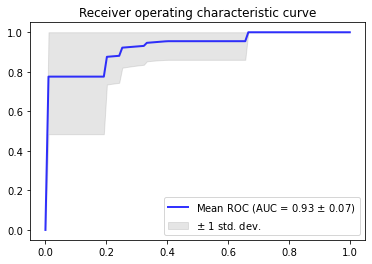

In [31]:
fig, ax = plt.subplots(1, 1)
ax = _plot_roc_curve(mean_tpr, mean_fpr, std_tpr, mean_auc, std_auc, ax=ax)

In [32]:
print(cv_clf)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              Scaler(info=<Info | 9 non-empty values
 bads: []
 ch_names: B'10, B'9, B'8, B'5, B'4, B'2, B'1, C'10, C'9, C'8, C'3, C'2, ...
 chs: 79 SEEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 1000.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nc...
                                      verbose=False),
                   iid='deprecated', n_iter=1, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [None],
                                        'randomforestclassifier__max_features': ['auto'],
                                        'randomforestclassifier__min_samples_split': [2],
                                        'randomforestclassifier__n_estimators': [200]},
      

# Show Card vs Show Reward

Can we visually distinguish the two?

In [6]:
# read epochs data
epochs_show, y = _load_data(bids_basename, bids_root, event_key='show card', verbose=False)

# make sure y labels are properly binarized
lb = LabelBinarizer(neg_label=0, pos_label=1)
y = lb.fit_transform(y)
# print(y)

# read in epochs data for fixation
epochs_fixate, y = _load_data(bids_basename, bids_root, event_key='show bet', verbose=False)

print(epochs_show, epochs_fixate)
print(epochs_show.get_data().shape)
print(epochs_fixate.get_data().shape)

# create X array
X = np.vstack((epochs_show.get_data(), epochs_fixate.get_data()))
y = np.hstack((np.ones(len(epochs_show)), np.zeros(len(epochs_fixate))))

print(X.shape, y.shape)

# features, so the resulting filters used are spatio-temporal
clf = make_pipeline(
    Scaler(epochs_show.info),  # apply z-normalization across all channels
    Vectorizer(),
    RandomForestClassifier()
)

# make sure to hold out some data as test
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(X_train.shape, y_train.shape, X.shape)

# feed in training to cross-validation, which will use training/validation data
# to iterate the classifier
cv_clf, outer_cv = cv_fit(clf, X_train, y_train, shuffle=True, apply_groups=False)

Out of 186 trials, there were 185 successful trials in sub-efri06_ses-efri_task-war_acq-seeg_run-01.
Extracting parameters from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_events.tsv.
Reading channel info from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_channels.tsv.
Out of 186 trials, there were 185 successful trials in sub-efri06_ses-efri_task-war_acq-seeg_run-01.
Out of 186 trials, there were 185 successful trials in sub-efri06_ses-efri_task-war_acq-seeg_run-01.
Extracting parameters from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efr

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   12.8s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.3s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.5s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.1s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.2s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.0s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.1s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.0s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.0s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.4s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   12.3s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    9.8s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.3s finished


   tpr  fpr  thresholds
0  NaN  NaN         NaN
1  NaN  NaN         NaN
2  NaN  NaN         NaN
Average difference of -0.010714 with std. dev. of 0.000000.
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__max_depth': None}


[1. 0. 0. 1. 1. 1. 1. 1. 1.]
{0: 1.0, 1: 0.84, 2: 1.0, 3: 0.9285714285714286, 4: 0.888888888888889, 5: 0.85, 6: 1.0, 7: 1.0, 8: 0.8571428571428572, 9: 1.0}
[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757

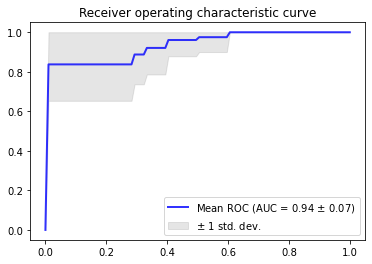

In [7]:
fpr, tpr, aucs, thresholds = dict(), dict(), dict(), dict()

# store ROC metrics
for i, (train, test) in enumerate(outer_cv.split(X=X_test, y=y_test)):
    # for binary classification get probability for class 1
    ypredict_proba = cv_clf.predict_proba(X_test[test])[:, 1]
    ytest = y_test[test]
    
    if np.unique(ytest).size == 1:
        continue

    # print(ytest.shape, ypredict_proba.shape)
    # print(ypredict_proba)
    # print(ytest)

    # compute the curve and AUC
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_true=ytest,
                                              # pos_label=1,
                                              y_score=ypredict_proba)
    aucs[i] = roc_auc_score(y_true=ytest, y_score=ypredict_proba)
    
    
print(ytest)
print(aucs)

# compute statistics on the ROC curve
mean_fpr, mean_tpr, std_tpr = _generate_linspace_roc_from_dict(fpr.values(),  tpr.values(), 
                                                               n_points=100)

mean_auc, std_auc = np.mean(list(aucs.values())), np.std(list(aucs.values()))

print(mean_fpr, mean_tpr, std_tpr)
print(mean_auc, std_auc)

fig, ax = plt.subplots(1, 1)
ax = _plot_roc_curve(mean_tpr, mean_fpr, std_tpr, mean_auc, std_auc, ax=ax)

# Which Card?

Here, we try to classify which card was shown (i.e. high or low)?

In [4]:
# read epochs data
epochs_show, y = _load_data(bids_basename, bids_root, 
                            label_keyword='subject_card', 
                            event_key='show card', verbose=False)

# map y to high and low card
y[y==2] = 0
y[y==4] = 0
y[y==8] = 1
y[y==10] = 1

six_inds = np.where(y == 6)[0]
print(six_inds)

epochs_show = epochs_show.drop(six_inds)
y = np.delete(y, six_inds)

print(epochs_show, y.shape)
print(np.unique(y))
# make sure y labels are properly binarized
lb = LabelBinarizer(neg_label=0, pos_label=1)
y = lb.fit_transform(y)
# print(y)

# create X array
X = epochs_show.get_data()

print(X.shape, y.shape)

# features, so the resulting filters used are spatio-temporal
clf = make_pipeline(
    Scaler(epochs_show.info),  # apply z-normalization across all channels
    Vectorizer(),
    RandomForestClassifier()
)

# make sure to hold out some data as test
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(X_train.shape, y_train.shape, X.shape)

# feed in training to cross-validation, which will use training/validation data
# to iterate the classifier
cv_clf, outer_cv = cv_fit(clf, X_train, y_train, shuffle=True, apply_groups=False)

Out of 186 trials, there were 185 successful trials in sub-efri06_ses-efri_task-war_acq-seeg_run-01.
Extracting parameters from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_events.tsv.
Reading channel info from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_channels.tsv.
Out of 186 trials, there were 185 successful trials in sub-efri06_ses-efri_task-war_acq-seeg_run-01.
[  4   5   6   7   8  20  39  42  44  49  53  58  59  64  66  67  72  76
  78  79  86  89  91  99 106 109 115 116 123 134 136 145 147 148 156 158
 159 162 168 173 177 178]
<Epochs  |   144 events (all good), 0 - 0.5 sec, baseline off, ~87.0 MB, data loaded,
 '10011': 144> (144,)
[0. 1.]
(144, 79, 1001) (144, 1)
(108, 79, 1001) (108, 1) (144, 79, 1001)
{

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.1s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.8s finished


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  30  31  32  34  35  36  37
  38  39  41  43  44  45  46  47  48  49  50  51  53  54  55  56  58  60
  61  63  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107] [29 33 40 42 52 57 59 62 64 81 82]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18
  19  20  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  56  57
  58  59  60  61  62  64  65  66  67  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  88  89  90  91  92  94  95  97  98
  99 100 101 103 105 106 107] [ 17  27  54  55  63  68  87  93  96 102 104]
[  0   2   3   4   5   6   7   8  10  11  12  13  14  15  16  17  18  19
  21  22  23  24  25  26  27  28  29  30  31  33  34  36

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.0s finished


   tpr  fpr  thresholds
0  NaN  NaN         NaN
1  NaN  NaN         NaN
2  NaN  NaN         NaN
Average difference of 0.020000 with std. dev. of 0.000000.
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__max_depth': None}


[[0]
 [1]
 [1]]
{0: 0.5, 1: 0.5, 2: 1.0, 3: 0.0, 4: 0.3333333333333333, 5: 1.0, 6: 0.0, 7: 0.5, 9: 0.5}
[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.8

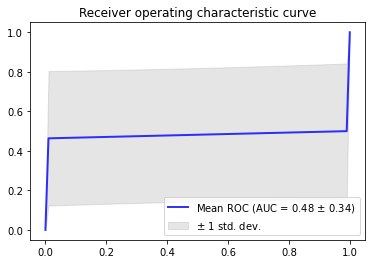

In [5]:
fpr, tpr, aucs, thresholds = dict(), dict(), dict(), dict()

# store ROC metrics
for i, (train, test) in enumerate(outer_cv.split(X=X_test, y=y_test)):
    # for binary classification get probability for class 1
    ypredict_proba = cv_clf.predict_proba(X_test[test])[:, 1]
    ytest = y_test[test]
    
    if np.unique(ytest).size == 1:
        continue

    # print(ytest.shape, ypredict_proba.shape)
    # print(ypredict_proba)
    # print(ytest)

    # compute the curve and AUC
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_true=ytest,
                                              # pos_label=1,
                                              y_score=ypredict_proba)
    aucs[i] = roc_auc_score(y_true=ytest, y_score=ypredict_proba)
    
    
print(ytest)
print(aucs)

# compute statistics on the ROC curve
mean_fpr, mean_tpr, std_tpr = _generate_linspace_roc_from_dict(fpr.values(),  tpr.values(), 
                                                               n_points=100)

mean_auc, std_auc = np.mean(list(aucs.values())), np.std(list(aucs.values()))

print(mean_fpr, mean_tpr, std_tpr)
print(mean_auc, std_auc)

fig, ax = plt.subplots(1, 1)
ax = _plot_roc_curve(mean_tpr, mean_fpr, std_tpr, mean_auc, std_auc, ax=ax)

# Which Bet?

Here, we try to classify which bet was taken (i.e. high or low)?

In [8]:
# read epochs data
epochs_low, y = _load_data(bids_basename, bids_root, 
                            label_keyword=None, 
                            event_key='bet 5', verbose=False)
ylow = np.zeros((len(epochs_low),))

epochs_high, y = _load_data(bids_basename, bids_root, 
                            label_keyword=None, 
                            event_key='bet 20', verbose=False)
yhigh = np.ones((len(epochs_high),))

epochs = mne.concatenate_epochs([epochs_low, epochs_high])
y = np.concatenate((ylow, yhigh))

# make sure y labels are properly binarized
lb = LabelBinarizer(neg_label=0, pos_label=1)
y = lb.fit_transform(y)
# print(y)


# create X array
X = epochs.get_data()

print(X.shape, y.shape)

# features, so the resulting filters used are spatio-temporal
clf = make_pipeline(
    Scaler(epochs_show.info),  # apply z-normalization across all channels
    Vectorizer(),
    RandomForestClassifier()
)

# make sure to hold out some data as test
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(X_train.shape, y_train.shape, X.shape)

# feed in training to cross-validation, which will use training/validation data
# to iterate the classifier
cv_clf, outer_cv = cv_fit(clf, X_train, y_train, shuffle=True, apply_groups=False)

Extracting parameters from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_events.tsv.
Reading channel info from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_channels.tsv.
Out of 186 trials, there were 185 successful trials in sub-efri06_ses-efri_task-war_acq-seeg_run-01.
Extracting parameters from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_events.tsv.
Reading channel info from /Users/adam2392/Dropbox/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-war_acq-seeg_run-01_channels.tsv.
Out of 186 tr

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    7.2s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.4s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/reduction.py", line 247, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/reduction.py", line 240, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/cloudpickle/cloudpickle_fast.py", line 538, in dump
    return Pickler.dump(self, obj)
  File "/Users/adam2392/

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/reduction.py", line 247, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/reduction.py", line 240, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/cloudpickle/cloudpickle_fast.py", line 538, in dump
    return Pickler.dump(self, obj)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/_memmapping_reducer.py", li

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed


Fitting 10 folds for each of 1 candidates, totalling 10 fits


    obj_ = dumps(obj, reducers=reducers)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/reduction.py", line 247, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/reduction.py", line 240, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/cloudpickle/cloudpickle_fast.py", line 538, in dump
    return Pickler.dump(self, obj)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/_memmapping_reducer.py", line 340, in __call__
    os.chmod(dumped_filename, FILE_PERMISSIONS)
FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/0p/knts5_1j38j6wvv3w_19584r0000gn/T/joblib_memmapping_folder_45832_2206607071/45832-5007935904-34bc179365fc49d484d16485461bd5f6.pkl'

During han

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
exception calling callback for <Future at 0x12a6149a0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/parallel.py", line 340, in __call__
    self.parallel.dispatch_next()
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/parallel.py", line 769, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, 

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/reduction.py", line 247, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/reduction.py", line 240, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/cloudpickle/cloudpickle_fast.p

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
exception calling callback for <Future at 0x12a7f07c0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/parallel.py", line 340, in __call__
    self.parallel.dispatch_next()
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/parallel.py", line 769, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, 

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/reduction.py", line 247, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/reduction.py", line 240, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/cloudpickle/cloudpickle_fast.py", line 538, in dump
    return Pickler.dump(self, obj)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/_memmapping_reducer.py", li

   tpr  fpr  thresholds
0  NaN  NaN         NaN
1  NaN  NaN         NaN
2  NaN  NaN         NaN
Average difference of    nan with std. dev. of    nan.
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__max_depth': None}


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/reduction.py", line 247, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/adam2392/miniconda3/envs/rf/lib/python3.8/site-packages/joblib/externals/loky/backend/reduction.py", line 240, in dump


[[1]
 [1]
 [0]
 [1]]
{0: 0.75, 1: 0.5, 2: 0.33333333333333337, 3: 0.25, 4: 0.6666666666666667, 5: 0.0, 6: 0.41666666666666663, 7: 1.0, 9: 0.0}
[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.7676767

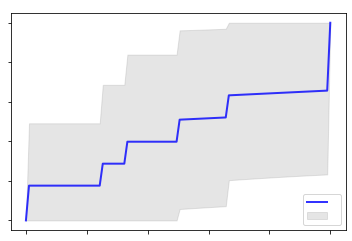

In [10]:
fpr, tpr, aucs, thresholds = dict(), dict(), dict(), dict()

# store ROC metrics
for i, (train, test) in enumerate(outer_cv.split(X=X_test, y=y_test)):
    # for binary classification get probability for class 1
    ypredict_proba = cv_clf.predict_proba(X_test[test])[:, 1]
    ytest = y_test[test]
    
    if np.unique(ytest).size == 1:
        continue

    # print(ytest.shape, ypredict_proba.shape)
    # print(ypredict_proba)
    # print(ytest)

    # compute the curve and AUC
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_true=ytest,
                                              # pos_label=1,
                                              y_score=ypredict_proba)
    aucs[i] = roc_auc_score(y_true=ytest, y_score=ypredict_proba)
    
    
print(ytest)
print(aucs)

# compute statistics on the ROC curve
mean_fpr, mean_tpr, std_tpr = _generate_linspace_roc_from_dict(fpr.values(),  tpr.values(), 
                                                               n_points=100)

mean_auc, std_auc = np.mean(list(aucs.values())), np.std(list(aucs.values()))

print(mean_fpr, mean_tpr, std_tpr)
print(mean_auc, std_auc)

fig, ax = plt.subplots(1, 1)
ax = _plot_roc_curve(mean_tpr, mean_fpr, std_tpr, mean_auc, std_auc, ax=ax)

# Discussion